This project creates a model that classifies handwritten 3s and 7s from the MNIST sample dataset.

In [1]:
!pip install -Uqq fastai

In [2]:
!pip install -Uqq fastbook

In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
Path.BASE_PATH = path

.BASE_PATH is an attribute to path that tells where the starting point is.  
If you run 'path' it shows you where it is

In [6]:
path

Path('.')

In [7]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

This lets us see what is in the directory.

In [8]:
type(path)

pathlib.PosixPath

pathlib is part of a Python standard library but doesn't have 'ls' command  so we have to add .ls. For instance path.ls().

In [9]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

This allows us to see what is in the train folder.

3s and 7s are labels/targets in the dataset.

In [10]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

This allows us to sort the data so that it is consistent/ get the same order of files.

In [11]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [12]:
sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

In [13]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

This allows us to see one image from the 3s folder after sorting.

In [14]:
type(im3)

PIL.PngImagePlugin.PngImageFile

The im3 image is a png file.  
We need to represent this in number format as everything is represented as numbers in computers.  
To view the number that represent this image we convert it to a Numpy array or PyTorch tensor.

To convert it to a Numpy array:


In [15]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

This shows us an index of a number at the top left from 4 up to the number before 10. (It does not include 10).  
[4:10, 4:10] represents [rows, columns]

There are 8 bit integer, thus between 0 and 255.

To convert to a PyTorch Tensor:
    

In [16]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

PyTorch tensors and Numpy arrays behave the same but PyToch tensors can be computed on GPU and not onlu in CPUs like numpy arrays.

In [17]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


im3_t = tensor(im3) -> grabs im3 and turns it to a tensor.  
df = pd.DataFrame(im3_t[4:15, 4:22]) -> grabs part of the image, that is [4:15, 4:22]  
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys') -> turns it to a panda's dataframe


Reason for turning it to a panda dataframe is because panda's dataframe has a convenient thing called background_gradient() that turns a background into a gradient.

In the output, 0s are the whites and 255 are the blacks. Then there are shades of grey that vary between 0 and 255.

## Creating a model that detects a 3

Idea is, if it doesn't recognise that a number is a 3, then it must be a 7.

### Pixel Similarity

- Find the average pixel value forevery pixe; of the threes and sevens.  
- The two group averages define the "ideal" 3 and 7.  
- Then to classify an image as a digit, we see which of these two ideal digits the image is similar to.

#### Create a baseline model

Baseline model -> a simple model which you are confident that it can perform reasonably well, should be simple to implement and easy to test.

First, we need to list all the images of sevens and threes as tensors.

In [18]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

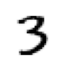

In [19]:
show_image(three_tensors[1]);

We can now display one of the 3s in the three_tensor list.  
Remember, this is a tensor and not a PIL image as we had seen before. Jupyter doesn't know how to display tensor so we use show_image().

We now need to get the average of all those 3s and 7s.  
First we need to change three_tensors and seven_tensors from lists, which can't easily do mathematical computations.

In [20]:
type(seven_tensors)

list

So we first stack all these 28×28 pixels images on top of each other to create like a 3D cube of images, quite like a tensor.

In [21]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

This turns the list to a tensor so the shape is now 6131 by 28 by 28.  
More like a cube of height 6131 that is 28×28.

Now if we are going to find the mean, we need to change them to floating point values because we don't want to kind of have integers rounding off.  
Also, its kind of a standard in computer vision that when you are working with floats, expect them to be between 0 and 1, so we divide by 255 because they are between 0 and 255.

The output is a Rank 3 tensor as it has three axes.

In [22]:
len(stacked_threes.shape)

3

We can also get it from 'ndim' that stands for number of dimensions.

In [23]:
stacked_threes.ndim

3

Numpy tends to call it axis, PyTorch tends to call it dimension.

Rank -> Number of axes or dimensions in a tensor.  
Shape -> Size of each axis of a tensor.

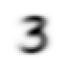

In [24]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

This gives us the mean of just the 0 axis, that is the mean across the images.  
Takes the mean across the 6131 axis.

When we show the image, we get the 'ideal' 3.

Now we, we can do the same for 7:

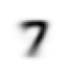

In [25]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

This shows us the 'ideal' 7.

Now, let's grab a 3:

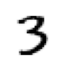

In [26]:
a_3 = stacked_threes[1]
show_image(a_3);

We can find if the a_3 is similar to the 'ideal' 3 or 7.  
The one that is more similar to, that's the answer.

We just can't add up the difference between the pixel of the image and the ideal digit because some differences will be negative and some will be positive and they'll cancel out. This will result in an image thats too dark in some places and too light in others.

To avoid this, we have to make them all positive values.  
This can be achieved by:  
1) Finding the absolute values (simply means removing the minus sign), the take the average. This is called the Mean Absolute Difference or L1 norm.  
2) Take the square of each difference and the take the mean then find the square root to undo the squaring. This is called Root Mean Squared Error or L2 norm.
    

In [27]:
dist_3_abs = (a_3-mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [28]:
dist_7_abs = (a_3-mean7).abs().mean()
dist_7_sqr = ((a_3-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

We do for both 3 and 7.

The distance in terms of absolute from mean of 3 is 0.114 and mean of 7 is 0.1586 so its close to the mean of 3 than the mean of 7. Therefore, we can guess that its a 3 based on the mean absolute differences.  
This is same for the root mean squared error.

In the codes above, we don't have to write  minus abs() mean(), we can use L1_loss.  
Also, we don't have to write minus squared, we can write mse_loss, but it doesn't do the square root so we have to include .sqrt().

In [29]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

This can be found inside 'torch.nn.functional', which PyTorch recommends importing as F.

##### Numpy array and PyTorch tensors

To create an array or tensor, we can pass a list or lists or list of lists.

In [30]:
data = [[1, 2, 3], [4, 5, 6]]
arr = array(data)
tns = tensor(data)

In [31]:
# for numpy
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [32]:
#for PyTorch
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

To select a row:

In [33]:
tns[1]

tensor([4, 5, 6])

To select a column:
    

In [34]:
tns[:,1]

tensor([2, 5])

: means row because its in the fist spot so therefore ,: is the same as removing it.  
example:

In [35]:
tns[1,:]

tensor([4, 5, 6])

Is the same as,

In [36]:
tns[1]

tensor([4, 5, 6])

Combining the together:

In [37]:
tns[1, 1:3]

tensor([5, 6])

This gives the first row and everything from the first up to but not including the third column.

[start:end] -> means from start to end but not including end.

Using standard operators to add all elements by 1:


In [38]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

Finding the type:

In [39]:
tns.type()

'torch.LongTensor'

Multiplying by a float:

In [40]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

Tensor automatically changes from a int to a float.

### Computing metrics using broadcasting

Is our model good enough?  
To quantify this, we must define a metric.

Metric -> a number which is calculated from the predictions of our model and the correct labels in our dataset, in order to tell us how good our model is.

We ought to check our model is by calculating the metric, using our validation set.

First, lets create a tensor of our threes and sevens from our valid directory.

The following code does the similar process as what we had done in our training set:

In [41]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

The code goes through through everything in the validation set of 3.ls() opens and turns them into a tensor then stacks them all up. Next, it turns them into a float by dividing by 255.  
Same is done for the 7 folder

Then we check the shape.

Idea is, we want to create a function is_3 that will return true if we think something is a 3. So we have to check whether the digit we are testing on is closer to the 'ideal' three or seven.

Let's create a function that takes the difference between two things, takes the absolute value and then takes the mean.

In [42]:
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

The mnist_distance function takes the difference between two tensors, takes their absolute value then takes the mean.

mean((-1,-2)) -> takes the mean of the last and the second last dimension.  
This is going to take the mean of kind of the x and y axes.

It returns a single number which is the distance a_3 from the mean3. This is the same value as we got earlier.

We need to do this for every image in the validation set so as to find the overall metric.

In [43]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1328, 0.1523, 0.1245,  ..., 0.1383, 0.1280, 0.1138]),
 torch.Size([1010]))

Broadcasting is a magic trick of Python that allows us to pass the whole validation set against the mean3.

In our case, it returns 1010 numbers.  
Here, we are doing a-b on the 1010 images on the validation set.

In [44]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

Gives us a Rank 3 tensor

In [45]:
mean3.shape

torch.Size([28, 28])

Gives us a Rank 2 tensor.

Broadcasting means if the two shapes don't match, if they matched it would just subtract every corresponding item. But because they don't match it actually acts as if there is 1010 versions of 28×28 (tensor of mean3). So its actually going to subtract this from every single one of mean3 tensor from every tensor of the validation set.

Broadcating requires us to first understand the idea of element-wise operation:

In [46]:
tensor([1, 2, 3]) + tensor([4, 5, 6])

tensor([5, 7, 9])

This is element-wise operation.  
These are rank-1 tensor of size 3. As they match,it takes the corresponding items and adds them together.

In [47]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

When we have different shapes as described before, what it ends up doing is copying mean3 1010 times and acts as if we had valid_3_tens minus 1010 copies of mean3.

Then we find the absolute value and call mean((-1, -2)).

We can now create is_3 function:

In [48]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x,mean7)

The function figures out if the distance between the image in question (x) and mean3 is less than the distance between the image in question (x) and mean7. If it is, then its a 3.

Let's check with a_3:

In [49]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Checks whether the image is a 3 and turns it into a float.  
If true, it becomes a 1. like in the above code.

Using broadcating, we can check the whole validation dataset.

In [50]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

Now, we can calculate the accuracy of the threes and sevens by taking the average of the function for all 3s and 7s.

In [51]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = 1 - is_3(valid_7_tens).float().mean()
accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

This performs is_3 on our whole valid_3_tens and then turns that into float and takes the mean. Same is done for 7.

Accuracy is 91% for 3s, 98% for 7s and 95% for both.   
This is a good baseline.

## Gradient Descent

But in ML, according to Arthur Samuel, we don't have a function which has parameters that we are testing against some kind of measure of fitness and then using it to improve the parameters. We just did one step.

Suppose, we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of the actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance.

We need some way to get our model to become better and better as we keep iterating. 
Let's think of a function which has parameters. So instead of finding an ideal image and seeing how far away something is from the ideal image, what we could instead do is come up with a set of weights for each pixel.
So in place that you expect to find 3, you could give those high weights.

We can come up with a function where the probability of something being, for example an 8, is equal  to the pixel in the image(x) multiplied by some sort of weight(w) then we sum up.  

def pr_eight(x,w): return (x*w).sum()

So anywhere in the image we are looking at with high weights, its going to end up with a high probability.

x is the image represented as a vector.

So here are the steps that we are going to require, to turn this function into a machine learning classifier:  
1) We will start with a vector w(A vector is a Rank 1 tensor) containing random weights/parameters.  
2) Then, we will predict whether the number is a 3 or 7.  
3) Based on the predictions, calculate how good the model is (its loss).  
4) Key step -> Calculate the gradient, which measure for each weight, how  changing that weight would change the loss.  
5) Step/Change all the weights based on that calculation.  
6) Go back to step 2 and repeat the process.  
7) ... repeat until you decide to stop the training process (for instance because the model is good enough).  

These steps are called Gradient Descent

Before going back to our image classifier, let's illustrate what they look like in a simple case.

#### Example 1

First, we define a simple function, the quadratic. Let's pretend this is our loss function and x is a weight parameter of the function.

In [52]:
def f(x): return x**2

plotting the graph:

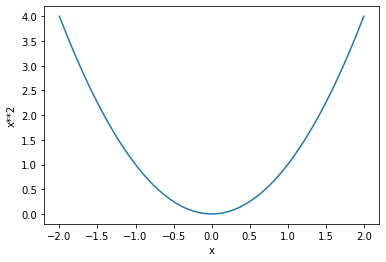

In [53]:
plot_function(f, 'x', 'x**2')

Next, we need to find the bottom value of the graph.  
The steps we described above starts by picking some random value for a parameter and calculating the value of the loss.

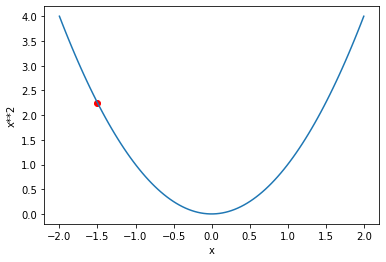

In [55]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

We pick 1.5.

Now we need to know if we increase x a bit, will x**2(the loss in this case) get better(better means the lossis smaller).

To get to the bottom of the curve, we need to calculate the gradient.  
First, we pick a tensor value which we want gradients at:

In [56]:
xt = tensor(3.).requires_grad_()